<a href="https://colab.research.google.com/github/ashley-m/DS6050/blob/main/CNN_imageclass_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

# Assignment 2: Designing an Architecture for Recognizing UVA Historical Landmarks
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this assignment, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 100 points for this assignment if you successfully transfer at least 3 existing architectures, plus 10 bonus points if your classifier performance exceeds 94% accuracy.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Canvas with the following format: yourcomputingID_assignment_2.ipynb

Best of luck, and have fun!

## TA's notes
Requirements:
- You must be able to implement a complete training/validation loop with a final test. The basic logic is similar to the FashionMNIST in previous tutorials.
- You must use 3 models. You could create/train all models from scratch or you can use transfer learning (for example, torchvision.models.resnet18) for one, two, or all of them. You may find CNN-specific architectures (e.g., LeNet, AlexNet, ResNet variants, GoogLeNet, VGG, etc) will be helpful. The most widely used CNN architectures include VGG-16 and ResNet-FPN-X101 (but they may be too big for Google Colab GPUs, so try small variants if that's the case). You could also try state-of-the-art Vision Transformers (ViT) but it's technically not a CNN so the rest of your models must both be CNN. ViTs might also be too big for the Google Colab GPUs. The above-mentioned architectures all have pretrained versions in [torchvision](https://pytorch.org/vision/stable/models.html).
- You can use the Sequential model creation instead of the class API, but that can make adding/changing various modules more difficult.
- Please split your own validation set. We've done this in previous tutorials also.
- Please do NOT change the random `SEED` or the test dataset/dataloader so I can verify your performance.
- Please also plot your training and loss curves. This way you and I will both understand the learning process and identify any problem.
- Please make your 3 models sufficiently different. For example, it's not enough to add one layer and call that a different model.

# Load Packages

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch


# Random Seed for Reproduction

In [2]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [3]:
# Download dataset from FirebaseStorage
!curl -L "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7" -o "dataset.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  378M  100  378M    0     0   143M      0  0:00:02  0:00:02 --:--:--  143M


In [4]:
# Extract content
!unzip -q "dataset.zip"


In [5]:
from sklearn.datasets import load_files

data_dir = "dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 296;
img_width = 296;


In [6]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder


TEST_RATIO = 0.2

# Download and load the training data
dataset_all = ImageFolder(
    data_dir,
    transform=ToTensor(),
)

size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')

# Calculate sizes of train-test-validation split
size_test = int(size_all * TEST_RATIO)
size_val = size_test
size_train = size_all - size_test - size_val

dataset_train_val, dataset_test = random_split(dataset_all, [size_all-size_test, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train_val)}. len(dataset_test)={len(dataset_test)}')

dataset_train, dataset_val = random_split(dataset_train_val, [size_train, size_val], generator=Generator().manual_seed(SEED*2))
print(f'After splitting the train dataset into train and validation: len(dataset_train)={len(dataset_train)}. len(dataset_val)={len(dataset_val)}')

Before splitting the full dataset into train and test: len(dataset_all)=14286
After splitting the full dataset into train and test: len(dataset_train)=11429. len(dataset_test)=2857
After splitting the train dataset into train and validation: len(dataset_train)=8572. len(dataset_val)=2857


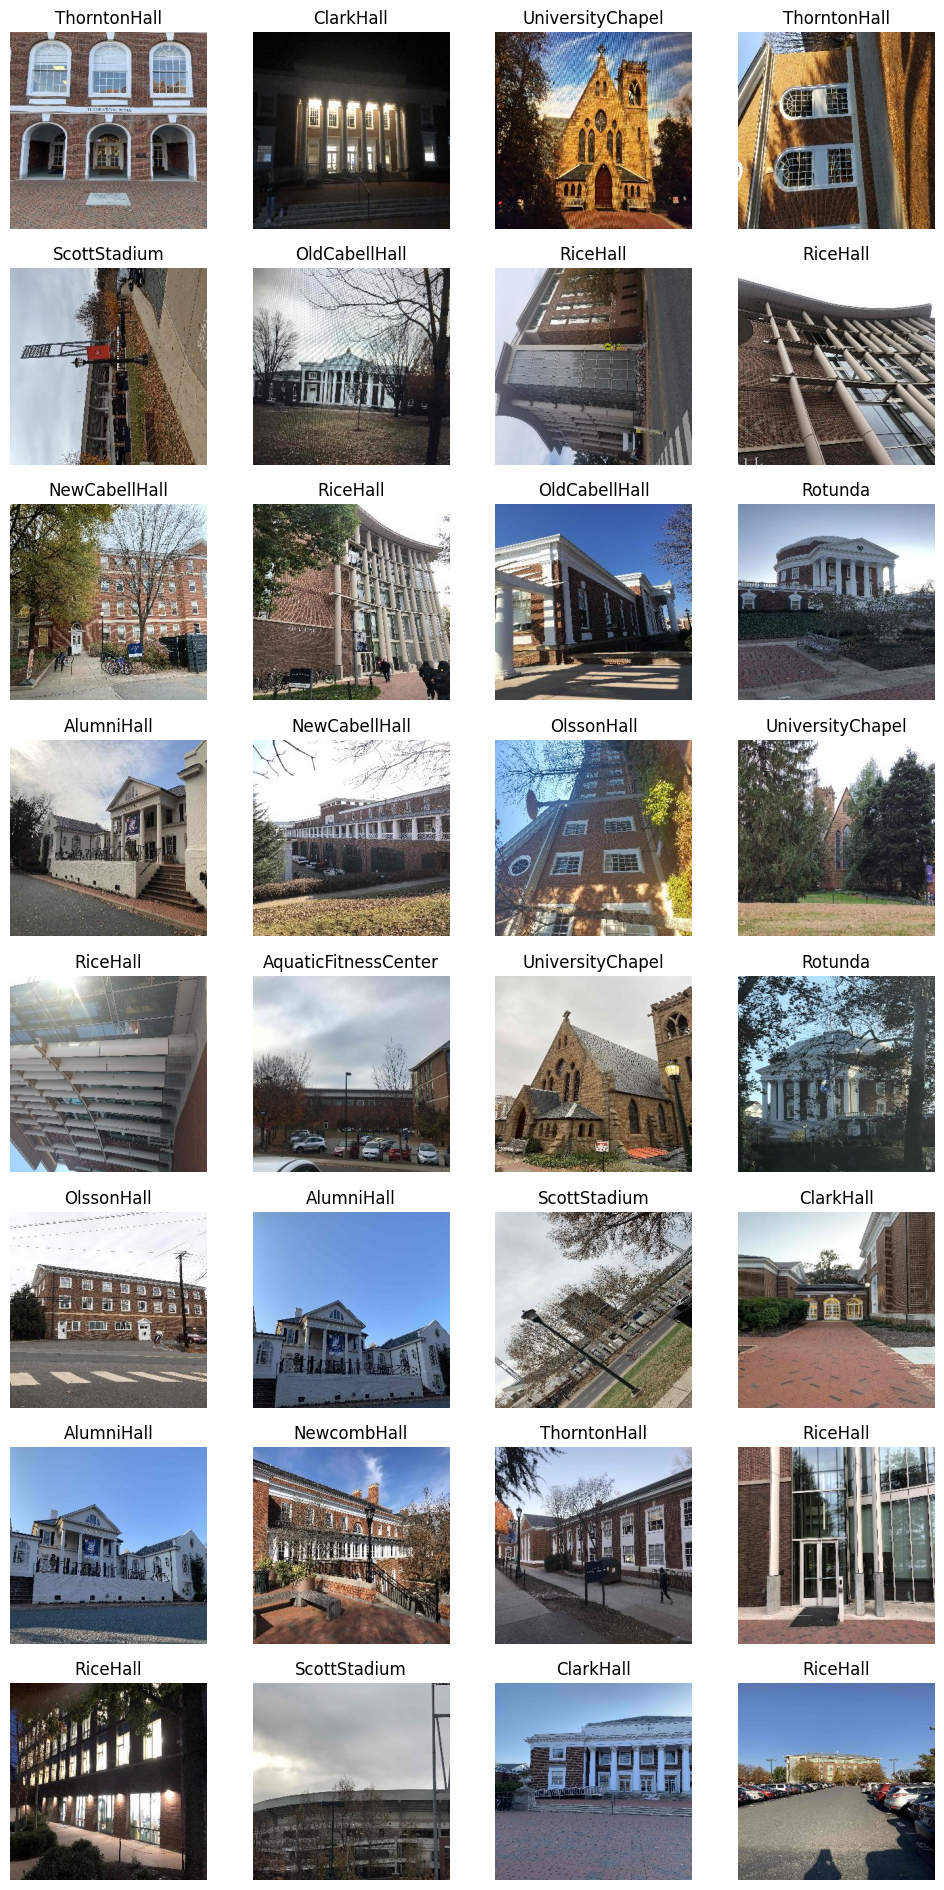

In [7]:
from torchvision.transforms.functional import to_pil_image


# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BravoHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

plt.show()

# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks.

Best of luck!

In [19]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.nn import DataParallel
import numpy as np

img_height = 224
img_width = 224
BATCH_SIZE = 32

# Define the transforms with calculated normalization
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply transforms to datasets
dataset_train.dataset.transform = train_transform
dataset_test.dataset.transform = test_transform

# Create DataLoaders
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset
    """
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            resize_transform = transforms.Resize((img_height, img_width))
            data = torch.stack([resize_transform(img) for img in data])
            data = data.to(device)
            target = target.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
from torch.nn import DataParallel

def train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    use_amp=True
):
    """
    Train a deep learning model with PyTorch.

    Parameters:
    - model: The neural network model.
    - train_dataloader: DataLoader for training data.
    - val_dataloader: DataLoader for validation data.
    - criterion: Loss function (e.g., nn.CrossEntropyLoss).
    - optimizer: Optimizer (e.g., torch.optim.Adam).
    - num_epochs: Number of training epochs.
    - device: Device to run the model on ('cuda' or 'cpu').
    - use_amp: Whether to use Automatic Mixed Precision (AMP) for training.

    Returns:
    - Dictionary containing training and validation loss/accuracy history.
    """
    model = model.to(device)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = DataParallel(model)

    scaler = amp.GradScaler(enabled=use_amp)  # Enable AMP if specified

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        ### Training Phase ###
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Get the device type ('cuda' or 'cpu')
            device_type = 'cuda' if device.type == 'cuda' else 'cpu'

            with amp.autocast(device_type=device_type, enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 350 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        ### Validation Phase ###
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                with amp.autocast(device_type=device_type, enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_dataloader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }


In [22]:
import torch.amp as amp
from torchvision.models import googlenet, GoogLeNet_Weights

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Load pre-trained GoogLeNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust output layer

# Disable auxiliary classifiers if not needed
model.aux_logits = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    use_amp=True
)


Using device: cpu
Epoch [1/10], Step [1/268], Loss: 2.9599


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label="Train Loss", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
# plt.ylim(2.5, 3)  # Exclude extreme values
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", alpha=0.7)
plt.plot(val_accuracies, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


mean, std = calculate_dataset_stats(DataLoader(dataset_test, batch_size=batch_size, shuffle=True))
model.set_test_mode(mean, std)

test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
accuracy = evaluate_model(model, test_dataloader, device)
print(f"Model Accuracy on Test Dataset: {accuracy:.2f}%")

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Load pre-trained DenseNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust output layer

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    use_amp=True
)


In [ ]:
plt.plot(train_losses, label="Train Loss", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
# plt.ylim(2.5, 3)  # Exclude extreme values
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", alpha=0.7)
plt.plot(val_accuracies, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


mean, std = calculate_dataset_stats(DataLoader(dataset_test, batch_size=batch_size, shuffle=True))
model.set_test_mode(mean, std)

test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
accuracy = evaluate_model(model, test_dataloader, device)
print(f"Model Accuracy on Test Dataset: {accuracy:.2f}%")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.nn import DataParallel
import numpy as np

img_height = 224
img_width = 224
BATCH_SIZE = 16

# Define the transforms with calculated normalization
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply transforms to datasets
dataset_train.dataset.transform = train_transform
dataset_test.dataset.transform = test_transform

# Create DataLoaders
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch.amp as amp
from torchvision.models import resnet50, ResNet50_Weights

# Instantiate ResNet18 and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust the number of output classes

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    use_amp=True
)

Using 2 GPUs!
Epoch [1/10], Step [1/536], Loss: 2.9089
Epoch [1/10], Step [351/536], Loss: 0.3113
Epoch: 1/10, Final Loss: 0.9877, Accuracy: 0.7227
Epoch: 1/10, Validation Loss: 0.6215, Validation Accuracy: 0.8208
Epoch [2/10], Step [1/536], Loss: 0.1089
Epoch [2/10], Step [351/536], Loss: 0.2699
Epoch: 2/10, Final Loss: 0.4136, Accuracy: 0.8831
Epoch: 2/10, Validation Loss: 0.4757, Validation Accuracy: 0.8785
Epoch [3/10], Step [1/536], Loss: 0.0650
Epoch [3/10], Step [351/536], Loss: 0.2068
Epoch: 3/10, Final Loss: 0.2671, Accuracy: 0.9277
Epoch: 3/10, Validation Loss: 0.4842, Validation Accuracy: 0.8859
Epoch [4/10], Step [1/536], Loss: 0.1085
Epoch [4/10], Step [351/536], Loss: 0.3484
Epoch: 4/10, Final Loss: 0.2011, Accuracy: 0.9418
Epoch: 4/10, Validation Loss: 0.4243, Validation Accuracy: 0.8999
Epoch [5/10], Step [1/536], Loss: 0.2761
Epoch [5/10], Step [351/536], Loss: 0.0117
Epoch: 5/10, Final Loss: 0.1593, Accuracy: 0.9543
Epoch: 5/10, Validation Loss: 0.4703, Validation Acc

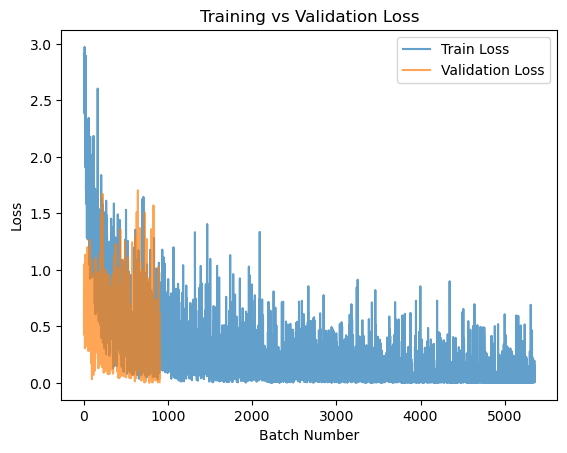

In [ ]:
plt.plot(batch_train_losses, label="Train Loss", alpha=0.7)
plt.plot(batch_val_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

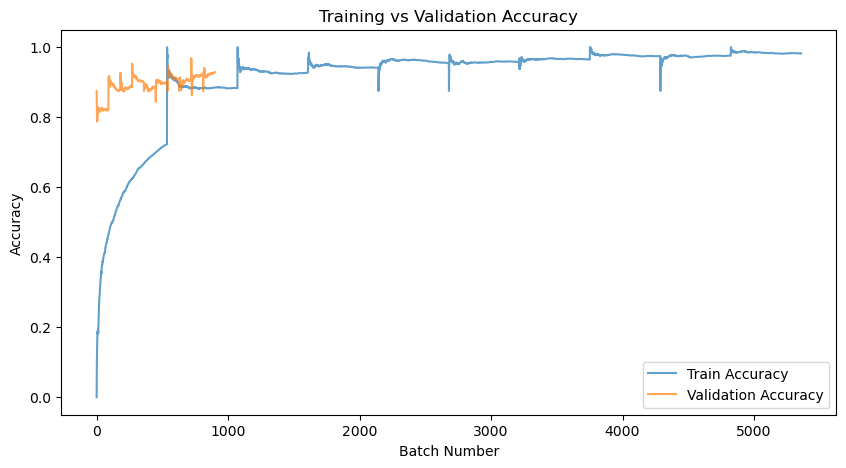

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(batch_train_accuracies, label="Train Accuracy", alpha=0.7)
plt.plot(batch_val_accuracies, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate on the test set after training
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9289
